In [2]:
import tensorflow as tf
from tensorflow.keras import models , layers
import matplotlib.pyplot as plt
import numpy as np

C:\Users\jaivi\anaconda3\New folder\New folder\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
IMAGE_SIZE = 255
BATCH_SIZE = 30
CHANNEL = 3
EPOCHES  = 5

In [4]:
dataset = tf.keras.preprocessing.image_dataset_from_directory("PLANT" ,
                             shuffle = True,              
                            image_size = (IMAGE_SIZE , IMAGE_SIZE),
                            batch_size = BATCH_SIZE )

Found 4500 files belonging to 3 classes.


In [5]:
# for class names
class_names = dataset.class_names
class_names

['Tomato_Early_blight', 'Tomato_Late_blight', 'Tomato_healthy']

In [6]:
len(dataset)

150

In [7]:
# for image  shape and batchshape
for image_batch , label_batch in dataset.take(3):
    print(image_batch.shape)
    print(label_batch.numpy())

(30, 255, 255, 3)
[1 1 2 2 0 1 0 2 0 1 1 1 1 0 1 2 2 2 0 2 1 2 1 2 2 1 2 2 0 2]
(30, 255, 255, 3)
[1 2 1 0 2 0 1 1 1 0 0 1 1 1 1 0 1 2 1 2 1 2 1 1 0 1 0 0 2 1]
(30, 255, 255, 3)
[1 2 1 0 0 2 0 1 2 0 0 2 1 2 1 0 0 1 2 2 2 2 0 0 0 1 1 2 1 2]


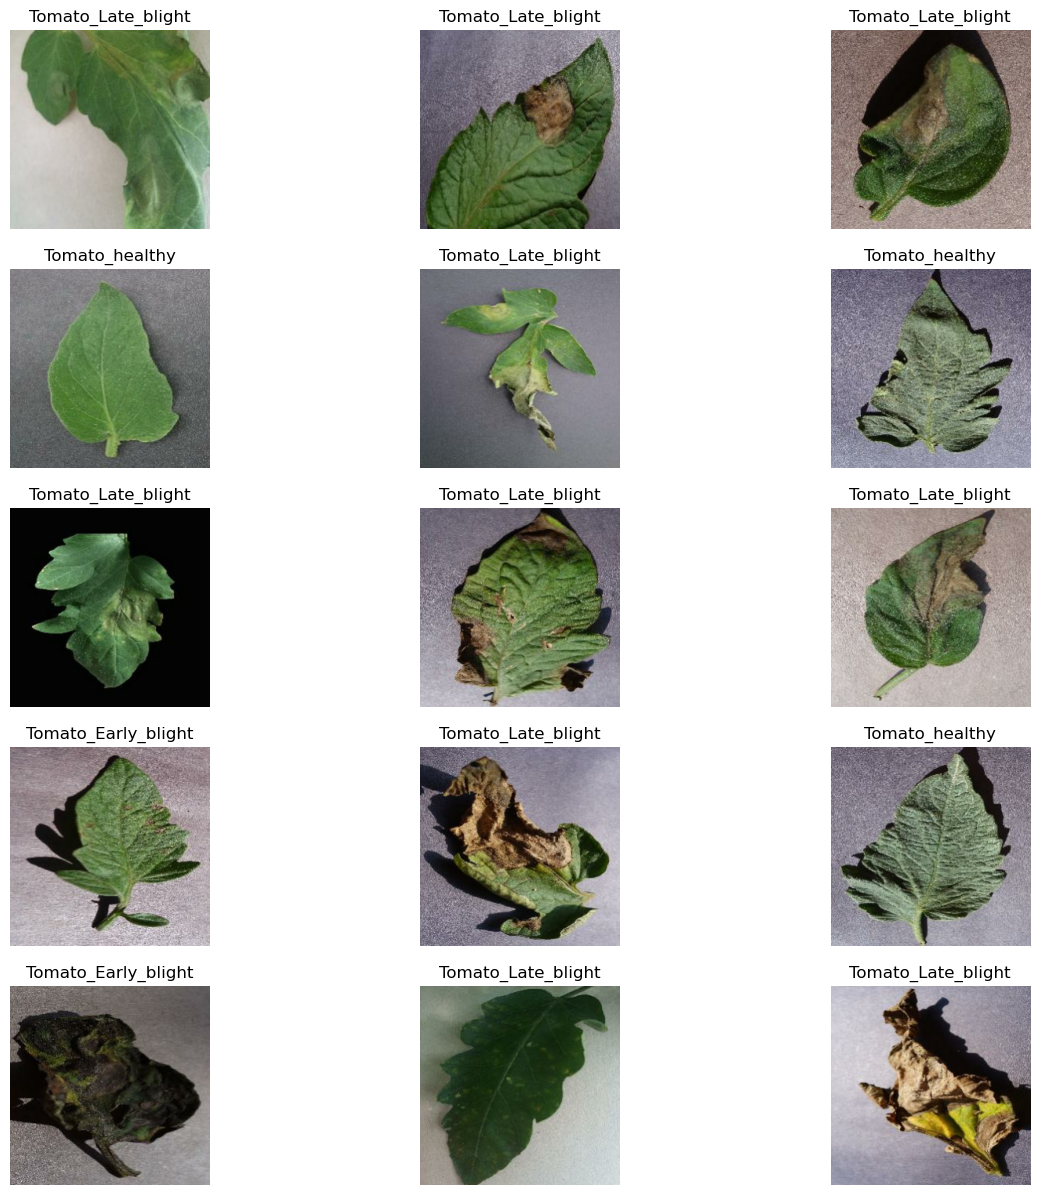

In [8]:
plt.figure(figsize = (15,15))
for image_batch , label_batch in dataset.take(1):
    for i in range(15):
            ax = plt.subplot(5,3 , i+1)
            plt.imshow(image_batch[i].numpy().astype("uint8"))
            plt.title(class_names[label_batch[i]])
            plt.axis("off")

In [9]:
# validation set for training the data 
#80% ==> training
#20% ==> 10% validation, 10% test
# test data set for performing the test 

In [10]:
len(dataset)

150

In [11]:
train_size = 0.8
len(dataset)*train_size

120.0

In [12]:
train_ds = dataset.take(237)
len(train_ds)

150

In [13]:
val_size = len(dataset)*0.1
val_size


15.0

In [14]:
val_ds = dataset.take(30)
len(val_ds)

30

In [15]:
test_ds = dataset.skip(237)

In [16]:
test_ds = test_ds.skip(30)
len(test_ds)

0

In [17]:
def dataset_partition_tf( data, train_split = 0.8 , val_split = 0.1 , test_split = 0.1 , shuffle =True  , shuffle_size = 1000 ):
    data_size = len(data)
    if shuffle:
        data = data.shuffle( shuffle_size  , seed =10)
        train_size = int(data_size* train_split)
        val_size = int(data_size*val_split)
        train_data = data.take(train_size)
        val_data = data.take(val_size)
        test_data = data.skip(train_size).take(val_size)
        return train_data , val_data , test_data
    

In [18]:
# for Train, Test split we using the above function
train_data , val_data , test_data = dataset_partition_tf(dataset)


In [19]:
len(test_data)

15

In [20]:
len(train_data)

120

In [21]:
len(val_data)

15

In [22]:
train_data = train_data.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
val_data = val_data.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
test_data = test_data.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)


In [23]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE , IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [24]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.4)
])

In [25]:
input_shape = (BATCH_SIZE , IMAGE_SIZE , IMAGE_SIZE , CHANNEL)
n_class = 6
model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D( 30 , (3,3) , activation ='relu' , input_shape = input_shape),
    layers.MaxPooling2D(2,2),
    layers.Conv2D( 60 , (3,3) , activation ='relu' , input_shape = input_shape),
    layers.MaxPooling2D(2,2),
    layers.Conv2D( 60 , (3,3) , activation ='relu' , input_shape = input_shape),
    layers.MaxPooling2D(2,2),
    layers.Conv2D( 60 , (3,3) , activation ='relu' , input_shape = input_shape),
    layers.MaxPooling2D(2,2),
    layers.Conv2D( 60 , (3,3) , activation ='relu' , input_shape = input_shape),
    layers.MaxPooling2D(2,2),
    layers.Conv2D( 60 , (3,3) , activation ='relu' , input_shape = input_shape),
    layers.MaxPooling2D(2,2),
    layers.Flatten(),
    layers.Dense(60 , activation = 'relu'),
    layers.Dense(n_class , activation = 'softmax'),
])
model.build(input_shape = input_shape)

In [26]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (30, 255, 255, 3)         0         
                                                                 
 sequential_1 (Sequential)   (30, 255, 255, 3)         0         
                                                                 
 conv2d (Conv2D)             (30, 253, 253, 30)        840       
                                                                 
 max_pooling2d (MaxPooling2D  (30, 126, 126, 30)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (30, 124, 124, 60)        16260     
                                                                 
 max_pooling2d_1 (MaxPooling  (30, 62, 62, 60)         0         
 2D)                                                  

In [27]:
model.compile(
    optimizer = 'adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = False),
    metrics = ['accuracy']
    
)

In [28]:
history = model.fit(
          train_data, 
          epochs = EPOCHES,
          batch_size = BATCH_SIZE,
          verbose = 1,
          validation_data = val_data
           
           )

Epoch 1/5
120/120 [==============================] - 264s 2s/step - loss: 1.0416 - accuracy: 0.4506 - val_loss: 0.9794 - val_accuracy: 0.4978
Epoch 2/5
120/120 [==============================] - 236s 2s/step - loss: 0.6751 - accuracy: 0.7075 - val_loss: 0.5230 - val_accuracy: 0.7378
Epoch 3/5
120/120 [==============================] - 216s 2s/step - loss: 0.4865 - accuracy: 0.8092 - val_loss: 0.6284 - val_accuracy: 0.7800
Epoch 4/5
120/120 [==============================] - 216s 2s/step - loss: 0.3759 - accuracy: 0.8361 - val_loss: 0.3047 - val_accuracy: 0.8711
Epoch 5/5
120/120 [==============================] - 217s 2s/step - loss: 0.3424 - accuracy: 0.8611 - val_loss: 0.2649 - val_accuracy: 0.8956


In [29]:
score  = model.evaluate(test_data)

15/15 [==============================] - 13s 450ms/step - loss: 0.2672 - accuracy: 0.8956


In [30]:
score

[0.26715797185897827, 0.8955555558204651]

In [31]:
history

In [32]:
history.params

{'verbose': 1, 'epochs': 5, 'steps': 120}

In [33]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [34]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

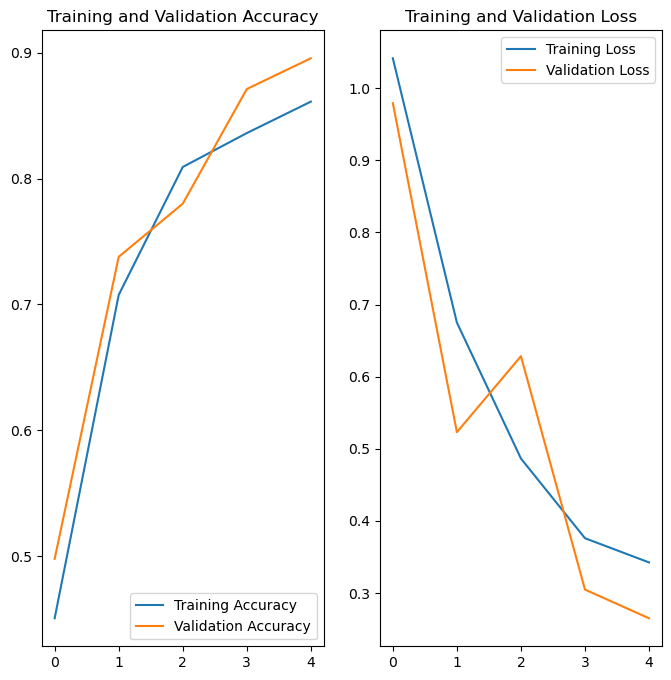

In [35]:
plt.figure(figsize = (8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHES) , acc, label = 'Training Accuracy')
plt.plot(range(EPOCHES) , val_acc , label = 'Validation Accuracy')
plt.legend(loc = 'lower right')
plt.title('Training and Validation Accuracy')
 
    
plt.subplot(1,2,2)
plt.plot(range(EPOCHES) ,loss , label = 'Training Loss')
plt.plot(range(EPOCHES) ,val_loss, label = 'Validation Loss' )
plt.legend(loc ='upper right')
plt.title('Training and Validation Loss')
plt.show()

 first image to predict
actual label : Tomato_healthy
1/1 [==============================] - 0s 329ms/step
predicted label : Tomato_healthy


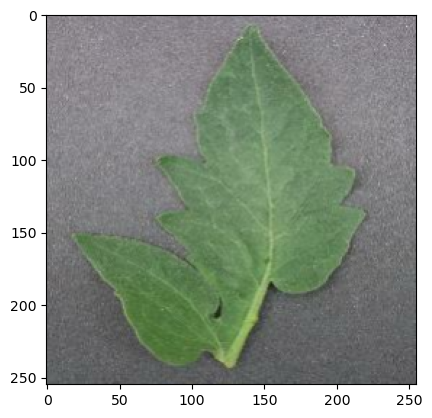

In [56]:
for image_batch , label_batch in test_data.take(1):
#     plt.imshow(image_batch[0].numpy().astype('unit8'))
#      print(image_batch[0].numpy().astype('unit8'))
        first_image = image_batch[0].numpy().astype("uint8")
        first_label = label_batch[0].numpy()
        print(" first image to predict")
        plt.imshow(first_image)
        print("actual label :" , class_names[first_label])
        batch_prediction = model.predict(image_batch)
        print( "predicted label :", class_names[np.argmax( batch_prediction[22])])

In [57]:
def predict( model , img):
    img_array = tf.keras.preprocessing.image.img_to_array(image[i].numpy())
    img_array = tf.expand_dims(img_array ,0)# Create a batch
    
    predictions = model.predict(img_array)
    
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence  = round( 100*(np.argmax(predictions[0])))
    return predicted_class , confidence

1/1 [==============================] - 0s 35ms/step


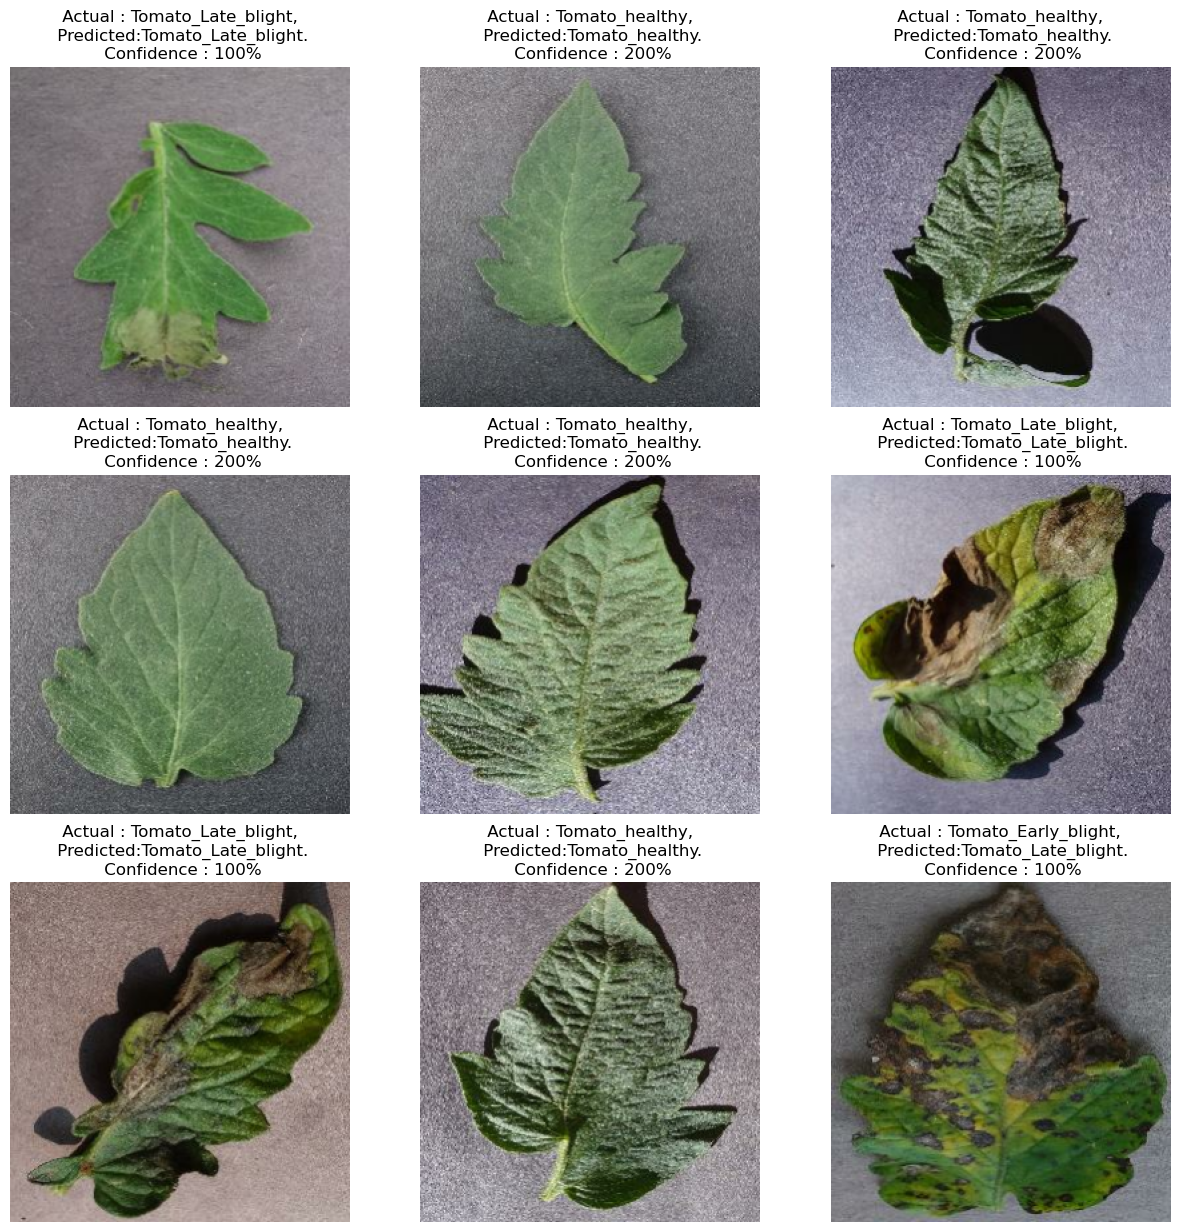

In [59]:
plt.figure(figsize =(15 ,15))
for image, label in test_data.take(1):
    for i in range(9):
        ax = plt.subplot(3,3 ,i+1)
        plt.imshow(image[i].numpy().astype("uint8"))
        
        predicted_class , confidence = predict(model , image[i].numpy())
        actual_class = class_names[label[i]]
        plt.title(f" Actual : { actual_class}, \n Predicted:{predicted_class}.\n Confidence : { confidence}%")
        plt.axis("off")